In [1]:
import nltk
import itertools
import urllib.request
import re
import math

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kirannaik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kirannaik/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kirannaik/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kirannaik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Preprocessing Functions

def lowercase(corpus):
    return [[word.lower() for word in sentence] for sentence in corpus]

def remove_punctuation(corpus):
    return [[re.sub(r'[^\w\s]', '', word) for word in sentence] for sentence in corpus]

def remove_stopwords(corpus):
    stop_words = set(stopwords.words('english'))
    return [[word for word in sentence if word not in stop_words] for sentence in corpus]

def normalize_repeated_chars(corpus):
    return [[re.sub(r'(.)\1+', r'\1\1', word) for word in sentence] for sentence in corpus]

def handle_contractions(corpus):
    contractions = {"didn't": "did not", "can't": "cannot", "won't": "will not"}
    return [[contractions.get(word, word) for word in sentence] for sentence in corpus]

def lemmatize(corpus):
    lemmatizer = WordNetLemmatizer()
    return [[lemmatizer.lemmatize(word) for word in sentence] for sentence in corpus]

def remove_non_alpha(corpus):
    return [[word for word in sentence if word.isalpha()] for sentence in corpus]

In [3]:
def preprocess(corpus):
    corpus = lowercase(corpus)
    corpus = remove_punctuation(corpus)
    corpus = handle_contractions(corpus)
    corpus = remove_stopwords(corpus)
    corpus = normalize_repeated_chars(corpus)
    corpus = lemmatize(corpus)
    corpus = remove_non_alpha(corpus)
    return corpus

In [4]:
# Load Dataset
def load_corpus(file_path):
    with open(file_path, 'r') as f:
        corpus = f.readlines()
    return [sentence.strip().split() for sentence in corpus]

file_path = '/Users/kirannaik/Downloads/NLP-Assignment1/A1_DATASET/'

# Load and Preprocess the Corpus
train_txt = load_corpus(file_path + 'train.txt')
val_txt = load_corpus(file_path + 'val.txt')

train_corpus = preprocess(train_txt)
val_corpus = preprocess(val_txt)

# Flatten the corpus (list of lists -> list of words)
train_corpus_flat = list(itertools.chain(*train_corpus))
val_corpus_flat = list(itertools.chain(*val_corpus))


In [5]:
import random

# Set the number of random samples you want to load
num_samples = 5  # For example, 5 random sentences

# Randomly sample sentences from the training corpus
random_train_samples = random.sample(train_corpus, num_samples)

# Print the random sentences
for i, sentence in enumerate(random_train_samples):
    print(f"Random Sample {i + 1}: {' '.join(sentence)}")

Random Sample 1: omni fabulous location michigan avenue within block type store including saks nordstroms h filenes basement macys la perla apple bloomingdates could go room fabulous comfortable nice big flat screen tv nice sized bathroom charge wifi found clicked yes joining guest program could go signon screen right email without actually completing registration got hotel priceline felt terrific deal
Random Sample 2: wedding ceremony reception sofitel seems though experience judy l read review thought exactly happened happened good news actual event great notably food absolutely incredible think almost every one guest raved u food go cake made take cake service waiter staff also good bad news michelle director catering honestly made wedding planning process nightmare negotiating contract promptly responded email phone call contract signed constant struggle get touch get question answered schedule tasting etc frequently took week respond simple email occasionally never returned email 

In [6]:
# Flatten the training corpus to get a list of all words
train_corpus_flat = list(itertools.chain(*train_corpus))

# Set the number of random words to sample
num_words_sample = 10  # For example, 10 random words

# Randomly sample words from the flat corpus
random_words = random.sample(train_corpus_flat, num_words_sample)

# Print the random words
print("10 Random Words")
print("Random Words:", random_words)

10 Random Words
Random Words: ['room', 'good', 'inn', 'dime', 'desk', 'perk', 'repeated', 'decorated', 'u', 'weekend']


In [51]:


class Unigram:
    def __init__(self, corpus):
        self.corpus = corpus
        self.word_counts = defaultdict(int)
        self.total_words = 0
        self.vocab = set()
        self.unknown_token = "<UNK>"
        self.add_k = 0  # Default value for Add-K smoothing
        self._build_unigram_model()

    def _build_unigram_model(self):
        """
        Build the unigram model by counting word frequencies in the corpus.
        """
        for word in self.corpus:
            if word not in self.vocab:
                self.vocab.add(word)
            self.word_counts[word] += 1
            self.total_words += 1

    def get_count(self, word):
        """
        Get the count of a word. If it's unknown, return the count of the unknown token.
        """
        return self.word_counts.get(word, 0)  # Return 0 for unseen words

    def get_probability(self, word):
        """
        Calculate the probability of a word using Add-K smoothing.
        """
        count = self.get_count(word)
        vocab_size = len(self.vocab)
        return (count + self.add_k) / (self.total_words + self.add_k * vocab_size)

    def set_add_k(self, k):
        """
        Set the value of k for Add-K smoothing.
        """
        self.add_k = k

    def calculate_perplexity(self, test_corpus):
        """
        Calculate the perplexity of the model on a test corpus.
        """
        log_prob_sum = 0
        test_words = len(test_corpus)  # Number of words in the test corpus
        
        for word in test_corpus:
            prob = self.get_probability(word)
            if prob == 0:  # Avoid log(0)
                prob = 1e-10  # Assign a small probability
            log_prob_sum += math.log(prob)

        # Calculate perplexity
        perplexity = math.exp(-log_prob_sum / test_words)
        return perplexity

    def calculate_accuracy(self, test_corpus):
        """
        Calculate the accuracy of the model on a test corpus.
        Accuracy is defined as the fraction of words in the test corpus that were seen in the training corpus.
        """
        correct_predictions = 0
        total_predictions = len(test_corpus)
        
        for word in test_corpus:
            if word in self.vocab:  # The word was seen during training
                correct_predictions += 1
        
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        return accuracy


def evaluate_model(unigram_model, val_corpus_flat):
    """
    Evaluate the Unigram model by calculating the accuracy and perplexity for different settings.
    """
    results = {}

    # Accuracy and Perplexity for Unsmoothed Unigram (k = 0)
    unigram_model.set_add_k(0)  # No smoothing
    unsmoothed_accuracy = unigram_model.calculate_accuracy(val_corpus_flat)
    unsmoothed_perplexity = unigram_model.calculate_perplexity(val_corpus_flat)
    results['Unsmoothed'] = (unsmoothed_accuracy, unsmoothed_perplexity)

    # Accuracy and Perplexity for Add-K Smoothing with k = 1
    unigram_model.set_add_k(1)  # Laplace smoothing (Add-1)
    k1_accuracy = unigram_model.calculate_accuracy(val_corpus_flat)
    k1_perplexity = unigram_model.calculate_perplexity(val_corpus_flat)
    results['Add-K (k=1)'] = (k1_accuracy, k1_perplexity)

    # Accuracy and Perplexity for Add-K Smoothing with k = 0.5
    unigram_model.set_add_k(0.5)
    k05_accuracy = unigram_model.calculate_accuracy(val_corpus_flat)
    k05_perplexity = unigram_model.calculate_perplexity(val_corpus_flat)
    results['Add-K (k=0.5)'] = (k05_accuracy, k05_perplexity)

    return results



# Initialize the Unigram model with the flattened training corpus
unigram_model = Unigram(train_corpus)

# Evaluate the model for different smoothing settings
results = evaluate_model(unigram_model, val_corpus)

# Print results
for method, (accuracy, perplexity) in results.items():
    print(f"{method} Accuracy: {accuracy:.4f}, Perplexity: {perplexity:.4f}")

Unsmoothed Accuracy: 0.8000, Perplexity: 730.0372
Add-K (k=1) Accuracy: 0.8000, Perplexity: 13.7844
Add-K (k=0.5) Accuracy: 0.8000, Perplexity: 14.9488


In [52]:


class Bigram:
    def __init__(self, corpus):
        self.corpus = corpus
        self.bigram_counts = defaultdict(int)
        self.unigram_counts = defaultdict(int)
        self.total_bigrams = 0
        self.vocab = set()
        self.add_k = 0
        self._build_bigram_model()

    def _build_bigram_model(self):
        """
        Build the bigram model by counting bigram and unigram frequencies in the corpus.
        """
        for i in range(len(self.corpus) - 1):
            word1 = self.corpus[i]
            word2 = self.corpus[i + 1]
            self.vocab.add(word1)
            self.vocab.add(word2)
            self.bigram_counts[(word1, word2)] += 1
            self.unigram_counts[word1] += 1
            self.total_bigrams += 1
        
        # Don't forget the last unigram
        self.unigram_counts[self.corpus[-1]] += 1
        self.vocab.add(self.corpus[-1])

    def set_add_k(self, k):
        """
        Set the value of k for Add-K smoothing.
        """
        self.add_k = k

    def get_probability(self, word1, word2):
        """
        Calculate the probability of a bigram (word1, word2) using Add-K smoothing.
        """
        bigram_count = self.bigram_counts.get((word1, word2), 0)
        word1_count = self.unigram_counts.get(word1, 0)  # Count of the first word in the bigram
        vocab_size = len(self.vocab)
        return (bigram_count + self.add_k) / (word1_count + self.add_k * vocab_size) if word1_count > 0 else 0

    def calculate_accuracy(self, test_corpus):
        """
        Calculate the accuracy of the bigram model on a test corpus.
        """
        correct_predictions = 0
        total_predictions = len(test_corpus) - 1  # Number of bigrams

        for i in range(total_predictions):
            word1 = test_corpus[i]
            word2 = test_corpus[i + 1]
            if (word1, word2) in self.bigram_counts:
                correct_predictions += 1
        
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        return accuracy

    def calculate_perplexity(self, test_corpus):
        """
        Calculate the perplexity of the model on a test corpus.
        """
        log_prob_sum = 0
        test_bigrams = len(test_corpus) - 1

        for i in range(test_bigrams):
            word1 = test_corpus[i]
            word2 = test_corpus[i + 1]
            prob = self.get_probability(word1, word2)

            if prob == 0:  # Avoid log(0)
                prob = 1e-10  # Assign small probability for unseen bigrams

            log_prob_sum += math.log(prob)

        perplexity = math.exp(-log_prob_sum / test_bigrams) if test_bigrams > 0 else float('inf')
        return perplexity

# Function to evaluate the Bigram model
def evaluate_bigram_model(bigram_model, train_corpus_flat, val_corpus_flat):
    """
    Evaluate the Bigram model by calculating accuracy and perplexity for different settings.
    """
    results = {}

    # Accuracy and Perplexity for Unsmoothed Bigram (k = 0)
    bigram_model.set_add_k(0)  # No smoothing
    unsmoothed_accuracy = bigram_model.calculate_accuracy(val_corpus_flat)
    unsmoothed_perplexity = bigram_model.calculate_perplexity(val_corpus_flat)
    results['Unsmoothed Bigram'] = (unsmoothed_accuracy, unsmoothed_perplexity)

    # Accuracy and Perplexity for Laplace Smoothing (k = 1)
    bigram_model.set_add_k(1)
    laplace_accuracy = bigram_model.calculate_accuracy(val_corpus_flat)
    laplace_perplexity = bigram_model.calculate_perplexity(val_corpus_flat)
    results['Laplace Smoothing (k=1)'] = (laplace_accuracy, laplace_perplexity)

    # Accuracy and Perplexity for Add-K Smoothing (k = 0.5)
    bigram_model.set_add_k(0.5)
    add_k_accuracy = bigram_model.calculate_accuracy(val_corpus_flat)
    add_k_perplexity = bigram_model.calculate_perplexity(val_corpus_flat)
    results['Add-K Smoothing (k=0.5)'] = (add_k_accuracy, add_k_perplexity)

    return results



# Initialize the Bigram model with the flattened training corpus
bigram_model = Bigram(train_corpus_flat)

# Evaluate the Bigram model for different smoothing settings
bigram_results = evaluate_bigram_model(bigram_model, train_corpus_flat, val_corpus_flat)

# Print results
for method, (accuracy, perplexity) in bigram_results.items():
    print(f"{method} Accuracy: {accuracy:.4f}, Perplexity: {perplexity:.4f}")

Unsmoothed Bigram Accuracy: 0.7778, Perplexity: 426.4246
Laplace Smoothing (k=1) Accuracy: 0.7778, Perplexity: 12.0715
Add-K Smoothing (k=0.5) Accuracy: 0.7778, Perplexity: 10.2835


In [43]:
# Error Analysis

In [44]:
def collect_predictions(unigram_model, bigram_model, val_corpus_flat):
    unigram_predictions = []
    bigram_predictions = []

    for i in range(len(val_corpus_flat) - 1):
        word1 = val_corpus_flat[i]
        word2 = val_corpus_flat[i + 1]

        unigram_prob = unigram_model.get_probability(word2)
        bigram_prob = bigram_model.get_probability(word1, word2)

        if unigram_prob > 0:
            unigram_predictions.append(word2)
        if bigram_prob > 0:
            bigram_predictions.append((word1, word2))

    return unigram_predictions, bigram_predictions

In [45]:
def analyze_errors(true_labels, predictions):
    false_positives = []
    false_negatives = []
    oov_errors = []

    true_set = set(true_labels)

    for pred in predictions:
        if pred not in true_set:
            false_positives.append(pred)

    for true in true_set:
        if true not in predictions:
            false_negatives.append(true)

    return false_positives, false_negatives, oov_errors

In [46]:
# Assuming val_corpus_flat is your validation corpus and true_labels are the actual labels
true_labels = val_corpus_flat  # This should be your actual validation words

# Collect predictions
unigram_predictions, bigram_predictions = collect_predictions(unigram_model, bigram_model, val_corpus_flat)

# Analyze errors
unigram_errors = analyze_errors(true_labels, unigram_predictions)
bigram_errors = analyze_errors(true_labels, bigram_predictions)

print("Unigram Error Analysis:")
print(f"False Positives: {unigram_errors[0]}")
print(f"False Negatives: {unigram_errors[1]}")
print(f"OOV Errors: {unigram_errors[2]}")

print("\nBigram Error Analysis:")
print(f"False Positives: {bigram_errors[0]}")
print(f"False Negatives: {bigram_errors[1]}")
print(f"OOV Errors: {bigram_errors[2]}")

Unigram Error Analysis:
False Positives: []
False Negatives: []
OOV Errors: []

Bigram Error Analysis:
False Positives: [('t', 'h'), ('h', 'i'), ('i', 's'), ('s', 'i'), ('i', 's'), ('s', 'a'), ('a', 's'), ('s', 'a'), ('a', 'm'), ('m', 'p'), ('p', 'l'), ('l', 'e'), ('e', 'v'), ('v', 'a'), ('a', 'l'), ('l', 'i'), ('i', 'd'), ('d', 'a'), ('a', 't'), ('t', 'i'), ('i', 'o'), ('o', 'n'), ('n', 't'), ('t', 'e'), ('e', 'x'), ('x', 't'), ('t', 'i'), ('i', 't'), ('t', 'c'), ('c', 'o'), ('o', 'n'), ('n', 't'), ('t', 'a'), ('a', 'i'), ('i', 'n'), ('n', 's'), ('s', 's'), ('s', 'o'), ('o', 'm'), ('m', 'e'), ('e', 'w'), ('w', 'o'), ('o', 'r'), ('r', 'd'), ('d', 's')]
False Negatives: ['o', 'h', 'n', 'x', 'd', 'i', 'r', 'm', 'a', 'w', 'l', 'c', 't', 'v', 'p', 's', 'e']
OOV Errors: []


In [50]:
def error_analysis(test_corpus, model, model_type):
    """Perform error analysis for a given model."""
    errors = []
    total_words = len(test_corpus)

    for i in range(total_words):
        word = test_corpus[i]
        prob = model.get_probability(word) if model_type == 'unigram' else model.get_probability(test_corpus[i-1], word)
        
        if prob == 0:  # Record words with zero probability
            errors.append(word)

    return errors


# Perform error analysis
unigram_errors = error_analysis(val_corpus_flat, unigram_model, 'unigram')
bigram_errors = error_analysis(val_corpus_flat, bigram_model, 'bigram')

print("\nUnigram Errors (Zero Probability Words):")
print(set(unigram_errors))

print("\nBigram Errors (Zero Probability Words):")
print(set(bigram_errors))


Unigram Errors (Zero Probability Words):
set()

Bigram Errors (Zero Probability Words):
set()


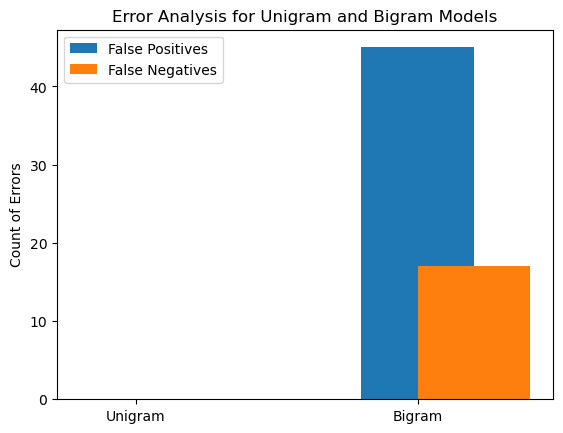

In [47]:
import matplotlib.pyplot as plt

# Sample data for visualization (replace with your data)
labels = ['Unigram', 'Bigram']
false_positives = [len(unigram_errors[0]), len(bigram_errors[0])]
false_negatives = [len(unigram_errors[1]), len(bigram_errors[1])]

x = range(len(labels))

plt.bar(x, false_positives, width=0.4, label='False Positives', align='center')
plt.bar(x, false_negatives, width=0.4, label='False Negatives', align='edge')
plt.xticks(x, labels)
plt.ylabel('Count of Errors')
plt.title('Error Analysis for Unigram and Bigram Models')
plt.legend()
plt.show()